## Run the following cell if things are not installed.

In [ ]:
# Install PennyLane and TensorFlow dependencies
!pip install pennylane
!pip install pennylane-tf
!pip install tensorflow
!pip install matplotlib
!pip install numpy

# Start Here

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Qiskit imports
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.providers.basic_provider import BasicSimulator

# Check versions
import importlib
print(f"TensorFlow version: {tf.__version__}")
print(f"PennyLane version: {qml.__version__}")
print(f"Qiskit version: {qiskit.__version__}")
try:
    import qiskit_aer
    print(f"Qiskit Aer version: {qiskit_aer.__version__}")
except ImportError:
    print("Qiskit Aer not installed")
try:
    import qiskit_ibm_runtime
    print(f"Qiskit IBM Runtime version: {qiskit_ibm_runtime.__version__}")
except ImportError:
    print("Qiskit IBM Runtime not installed")


2025-04-06 19:20:05.259586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743967205.270468   18390 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743967205.273755   18390 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743967205.283045   18390 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743967205.283062   18390 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743967205.283064   18390 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
PennyLane version: 0.40.0
Qiskit version: 1.2.4
Qiskit Aer version: 0.16.0
Qiskit IBM Runtime version: 0.29.0


In [3]:

################################################################################
# Setting of the main hyper-parameters of the model
#-------------------------------------------------------------------------------

n_epochs = 30    # Number of optimization epochs
n_layers = 1     # Number of random layers
n_train = 50     # Size of the train dataset
n_test = 30      # Size of the test dataset

SAVE_PATH = "quanv_data/"  # Data saving folder
# If the folder does not exist, create it
import os
os.makedirs(SAVE_PATH, exist_ok=True)

PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator


In [4]:

import tensorflow_datasets as tfds
# Dataset selection 
# 1 = MNIST (default)
# 2 = CIFAR
# 3 = Fashion
dataset_sel = 2

################################################################################
# Loading of the CIFAR-10 dataset
#-------------------------------------------------------------------------------
if dataset_sel == 2:
    cifar_dataset = keras.datasets.cifar10
    (train_images, train_labels), (test_images, test_labels) = cifar_dataset.load_data()

################################################################################
# Loading of the fashion dataset
#-------------------------------------------------------------------------------
elif dataset_sel == 3:
    fashion_mnist = keras.datasets.fashion_mnist
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    
################################################################################
# Loading of the MNIST dataset
#-------------------------------------------------------------------------------
else:
    mnist_dataset = keras.datasets.mnist
    (train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)


In [5]:

################################################################################
# Define quantum circuits for both PennyLane and Qiskit
#-------------------------------------------------------------------------------

# Random circuit parameters (shared between PennyLane and Qiskit)
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

# 1. PennyLane native implementation
dev_pennylane = qml.device("default.qubit", wires=4)

@qml.qnode(dev_pennylane)
def circuit_pennylane(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

# 2. PennyLane with Qiskit backend
dev_qiskit = qml.device("qiskit.basicsim", wires=4)

@qml.qnode(dev_qiskit)
def circuit_qiskit_pl(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]


In [6]:

################################################################################
# Quantum convolution functions for different backends
#-------------------------------------------------------------------------------

def quanv_pennylane(image):
    """Convolves the input image with PennyLane's native device."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit_pennylane(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c].item()
    return out

def quanv_qiskit_pl(image):
    """Convolves the input image with Qiskit backend through PennyLane."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit_qiskit_pl(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c].item()
    return out


In [7]:

################################################################################
# Quantum pre-processing of the dataset
#-------------------------------------------------------------------------------

if PREPROCESS:
    # PennyLane processing
    pl_train_images = []
    print("Quantum pre-processing of train images with PennyLane:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        pl_train_images.append(quanv_pennylane(img))
    pl_train_images = np.asarray(pl_train_images)

    pl_test_images = []
    print("\nQuantum pre-processing of test images with PennyLane:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        pl_test_images.append(quanv_pennylane(img))
    pl_test_images = np.asarray(pl_test_images)

    # Qiskit processing via PennyLane device
    qiskit_pl_train_images = []
    print("\nQuantum pre-processing of train images with Qiskit via PennyLane:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        qiskit_pl_train_images.append(quanv_qiskit_pl(img))
    qiskit_pl_train_images = np.asarray(qiskit_pl_train_images)

    qiskit_pl_test_images = []
    print("\nQuantum pre-processing of test images with Qiskit via PennyLane:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        qiskit_pl_test_images.append(quanv_qiskit_pl(img))
    qiskit_pl_test_images = np.asarray(qiskit_pl_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "pl_train_images.npy", pl_train_images)
    np.save(SAVE_PATH + "pl_test_images.npy", pl_test_images)
    np.save(SAVE_PATH + "qiskit_pl_train_images.npy", qiskit_pl_train_images)
    np.save(SAVE_PATH + "qiskit_pl_test_images.npy", qiskit_pl_test_images)

# Load pre-processed images
pl_train_images = np.load(SAVE_PATH + "pl_train_images.npy")
pl_test_images = np.load(SAVE_PATH + "pl_test_images.npy")
qiskit_pl_train_images = np.load(SAVE_PATH + "qiskit_pl_train_images.npy")
qiskit_pl_test_images = np.load(SAVE_PATH + "qiskit_pl_test_images.npy")


Quantum pre-processing of train images with PennyLane:
50/50        
Quantum pre-processing of test images with PennyLane:
30/30        
Quantum pre-processing of train images with Qiskit via PennyLane:
50/50        
Quantum pre-processing of test images with Qiskit via PennyLane:
30/30        

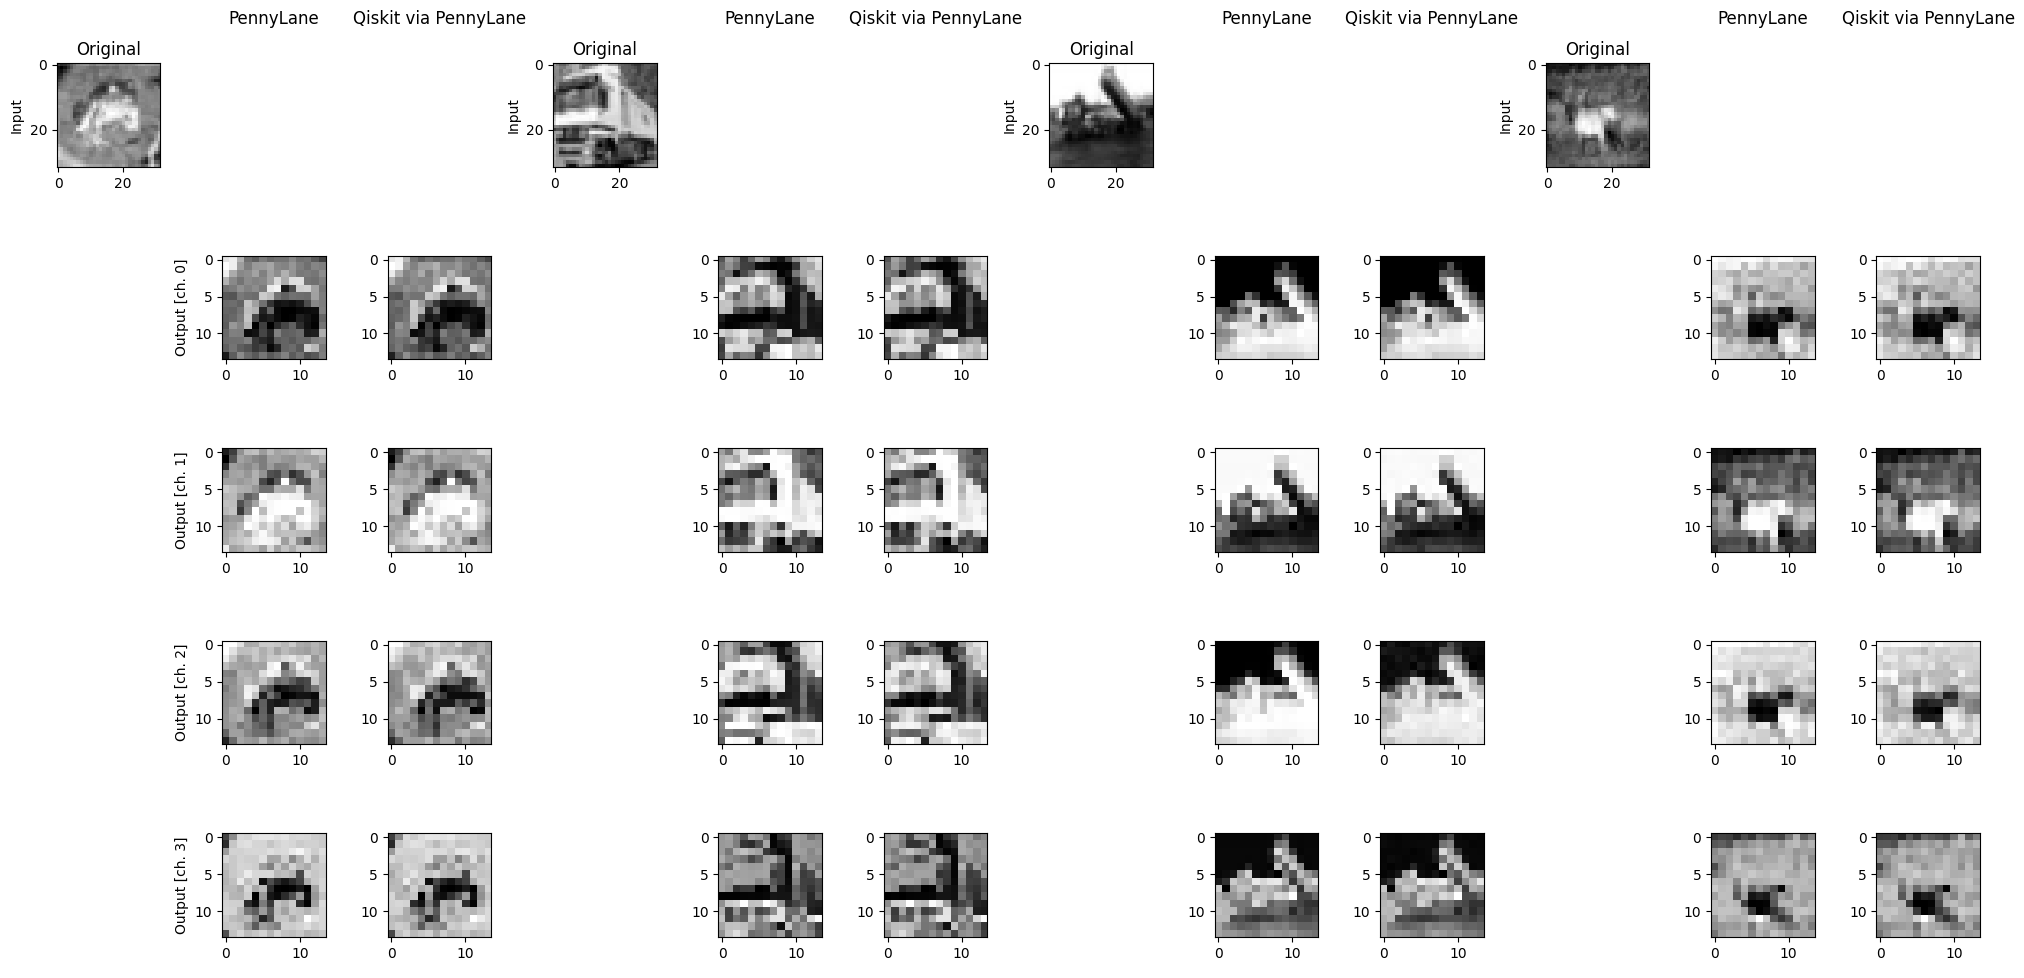

In [8]:

################################################################################
# Visualize the effect of quantum convolution with different backends
#-------------------------------------------------------------------------------

n_samples = 4
n_channels = 4
titles = ["Original", "PennyLane", "Qiskit via PennyLane"]
fig, axes = plt.subplots(1 + n_channels, n_samples * len(titles), figsize=(20, 10))

for k in range(n_samples):
    # Original image
    col = k * len(titles)
    axes[0, col].set_title(titles[0])
    axes[0, col].imshow(train_images[k, :, :, 0], cmap="gray")
    axes[0, col].set_ylabel("Input")
    
    # PennyLane processed
    col = k * len(titles) + 1
    axes[0, col].set_title(titles[1])
    for c in range(n_channels):
        if k == 0:
            axes[c + 1, col].set_ylabel(f"Output [ch. {c}]")
        axes[c + 1, col].imshow(pl_train_images[k, :, :, c], cmap="gray")
    
    # Qiskit via PennyLane
    col = k * len(titles) + 2
    axes[0, col].set_title(titles[2])
    for c in range(n_channels):
        axes[c + 1, col].imshow(qiskit_pl_train_images[k, :, :, c], cmap="gray")

# Hide empty plots in the first row 
for k in range(n_samples):
    for i in range(1, len(titles)):
        axes[0, k * len(titles) + i].axis('off')

# Hide empty plots in the first column of each channel
for k in range(n_samples):
    for i in range(1, n_channels + 1):
        axes[i, k * len(titles)].axis('off')



plt.tight_layout()
plt.show()


In [9]:

################################################################################
# Compare similarity between different backends
#-------------------------------------------------------------------------------

def compare_outputs(img1, img2):
    """Calculate mean squared error between two processed images"""
    return np.mean((img1 - img2)**2)

# Calculate MSE between PennyLane and Qiskit outputs
pl_qiskit_pl_mse = compare_outputs(pl_train_images, qiskit_pl_train_images)

print("Mean Squared Error between:")
print(f"PennyLane and Qiskit via PennyLane: {pl_qiskit_pl_mse:.6f}")


Mean Squared Error between:
PennyLane and Qiskit via PennyLane: 0.000714


In [10]:

################################################################################
# Hybrid quantum-classical model
#-------------------------------------------------------------------------------

def MyModel():
    """Initializes and returns a custom Keras model which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [11]:

################################################################################
# Train and validate models on different pre-processed datasets
#-------------------------------------------------------------------------------
with tf.device('/CPU:0'):
    # PennyLane model
    pl_model = MyModel()
    pl_history = pl_model.fit(
        pl_train_images,
        train_labels,
        validation_data=(pl_test_images, test_labels),
        batch_size=4,
        epochs=n_epochs,
        verbose=2,
    )
    
    # Qiskit via PennyLane model
    qiskit_pl_model = MyModel()
    qiskit_pl_history = qiskit_pl_model.fit(
        qiskit_pl_train_images,
        train_labels,
        validation_data=(qiskit_pl_test_images, test_labels),
        batch_size=4,
        epochs=n_epochs,
        verbose=2,
    )
    
    # Classical model (no quantum pre-processing)
    c_model = MyModel()
    c_history = c_model.fit(
        train_images,
        train_labels,
        validation_data=(test_images, test_labels),
        batch_size=4,
        epochs=n_epochs,
        verbose=2,
    )


W0000 00:00:1743967470.254334   18390 gpu_device.cc:2430] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1743967470.256266   18390 gpu_device.cc:2430] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1743967470.359848   18390 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29042 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5090, pci bus id: 0000:0a:00.0, compute capability: 12.0


Epoch 1/30


I0000 00:00:1743967471.001419   18519 service.cc:152] XLA service 0x7fecb0008990 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743967471.001452   18519 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-04-06 19:24:31.011827: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743967471.141121   18519 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 - 1s - 62ms/step - accuracy: 0.1200 - loss: 2.5460 - val_accuracy: 0.1000 - val_loss: 2.4694
Epoch 2/30
13/13 - 0s - 5ms/step - accuracy: 0.3000 - loss: 1.8618 - val_accuracy: 0.1333 - val_loss: 2.6530
Epoch 3/30
13/13 - 0s - 5ms/step - accuracy: 0.4800 - loss: 1.5573 - val_accuracy: 0.1333 - val_loss: 2.8253
Epoch 4/30
13/13 - 0s - 5ms/step - accuracy: 0.6200 - loss: 1.3342 - val_accuracy: 0.1000 - val_loss: 2.9355
Epoch 5/30
13/13 - 0s - 5ms/step - accuracy: 0.7200 - loss: 1.1444 - val_accuracy: 0.1333 - val_loss: 3.0142
Epoch 6/30
13/13 - 0s - 5ms/step - accuracy: 0.8000 - loss: 0.9888 - val_accuracy: 0.1000 - val_loss: 3.0870
Epoch 7/30
13/13 - 0s - 5ms/step - accuracy: 0.9000 - loss: 0.8618 - val_accuracy: 0.1000 - val_loss: 3.1571
Epoch 8/30
13/13 - 0s - 5ms/step - accuracy: 0.9200 - loss: 0.7565 - val_accuracy: 0.1000 - val_loss: 3.2230
Epoch 9/30
13/13 - 0s - 5ms/step - accuracy: 0.9600 - loss: 0.6679 - val_accuracy: 0.1000 - val_loss: 3.2853
Epoch 10/30
13/13 - 0s - 5ms/

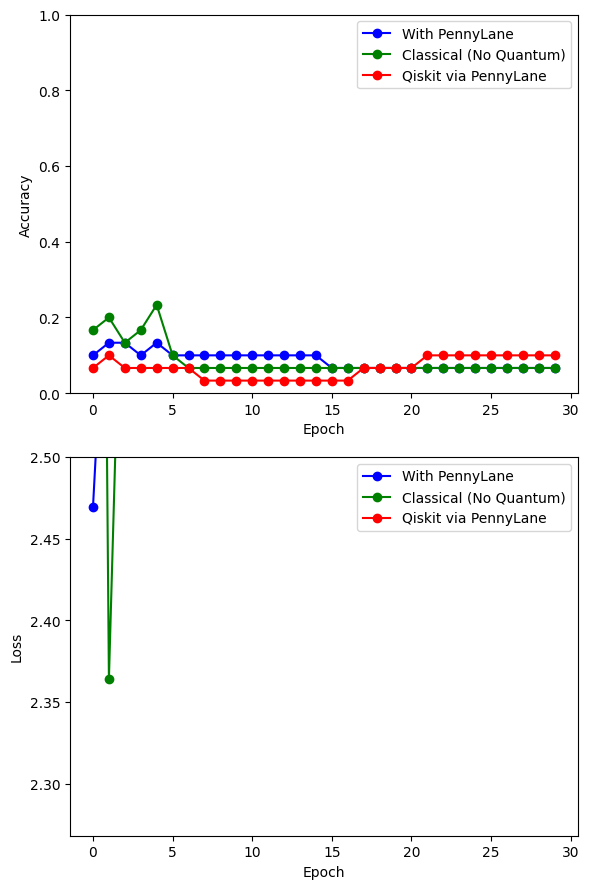

In [13]:
################################################################################
# Results
#-------------------------------------------------------------------------------

import matplotlib.pyplot as plt

# plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(pl_history.history["val_accuracy"], "-ob", label="With PennyLane")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Classical (No Quantum)")
ax1.plot(qiskit_pl_history.history["val_accuracy"], "-or", label="Qiskit via PennyLane")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(pl_history.history["val_loss"], "-ob", label="With PennyLane")
ax2.plot(c_history.history["val_loss"], "-og", label="Classical (No Quantum)")
ax2.plot(qiskit_pl_history.history["val_loss"], "-or", label="Qiskit via PennyLane")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()